# Chatper 3: Classification

In [1]:
import numpy as np
import os
import src.chapter3 as ch3
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# To plot pretty figures (copied and pasted from A.Geron's notebook)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

We read the MNIST data and reorder them as in the first edition of the book by using the `sort_by_train` function in the `chapter3` module.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.uint8)
ch3.sort_by_train(mnist)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

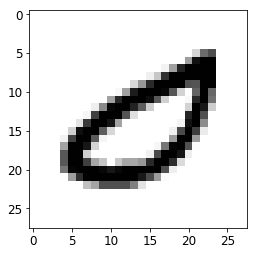

In [5]:
plt.imshow(X[1234].reshape(28, 28), cmap=mpl.cm.binary, interpolation='nearest')

If we plot all the 70,000 images (and play with the aspect ratio a bit) we can have an understanding of why a classifier that operates on flattened images can work so well. We can clearly see patterns in the images, corresponding to the various classes.
**TODO** it would be nice to have a colorbar showing which digit is being shown in the figure.

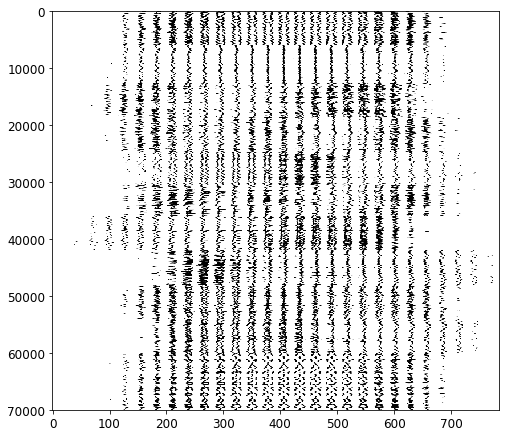

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(X, cmap=mpl.cm.binary, interpolation='nearest', aspect=.01)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We need to reshuffle the dataset. Note the use of `np.random.permutation` for this purpose. It is simpler and faster than shuffling and index of length 60000. Note also that we only need to shuffle the training set. There is no need to shuffle the test set.

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

We use a [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/sgd.html) classifer.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sum(y_train_5)

5421

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
cv_score

array([0.9502 , 0.96565, 0.96495])

In the book, A. Geron creates a `Never5Classifier` class that always predicts `False`. The same result can be obtained using a `DummyClassifier` from `sklearn.dummy`. Let's see if we obtain the same results.

In [12]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
cv_score_dummy = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [13]:
cv_score_dummy

array([0.90965, 0.90965, 0.90965])

As a comparison, let's create the `Never5Classifier` as shown in the book.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5_clf = Never5Classifier()
never5_score = cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
never5_score

array([0.909  , 0.90715, 0.9128 ])

## Using the confusion matrix

To use the confusion matrix appropriately we should use `cross_val_predict` to predict the labels in the training set. Since we are using a linear classifier, in this case the difference will probably be modest. Let's check. Let's first use the naive approach where we predict the lables of the training set using a model that has used it in its entirety.

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

naive_predictions = sgd_clf.predict(X_train)
cv_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
naive_conf_mat = confusion_matrix(y_train_5, naive_predictions)
cv_conf_mat = confusion_matrix(y_train_5, cv_predictions)

In [17]:
naive_conf_mat

array([[53470,  1109],
       [ 1003,  4418]])

In [18]:
cv_conf_mat

array([[53272,  1307],
       [ 1077,  4344]])

Even in a low-variance case like this one, we can see that the naive classifier is more optimistic than the CV one, and tends to underestimate the error in both classes.

## Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, cv_predictions))
print(recall_score(y_train_5, cv_predictions))
print(f1_score(y_train_5, cv_predictions))

0.7687135020350381
0.801328168234643
0.7846820809248555


### Digression: random oversampling and SGD

Let's see if, by using random oversampling, we manage to obtain a slightly better score.

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_ros, y_ros = ros.fit_resample(X_train, y_train_5)

x_ros.shape, y_ros.shape

In [25]:
cv_preds_ros = cross_val_predict(sgd_clf, x_ros, y_ros, cv=3)

In [27]:
print(precision_score(y_ros, cv_preds_ros))
print(recall_score(y_ros, cv_preds_ros))
print(f1_score(y_ros, cv_preds_ros))

0.8745261627403804
0.9257040253577383
0.8993876388493306


Indeed, using random over-sampling has produced a significant improvement in performance.

In [28]:
del x_ros, y_ros, cv_preds_ros

Note that in the Scikit-Learn documentation, they recommend using the [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) function to compute the metric scores, rather than passing the predictions from `cross_val_predict` to the scoring function.

## Decision Function Scores

Let's plot the distribution of the `decision_function` scores from the classifier. **TO CHECK** these scores are based on the over-sampled dataset, right? They should be somewhat more accurate than those obtained using the unbalanced dataset.

In [33]:
y_scores_ros = sgd_clf.decision_function(X_train)

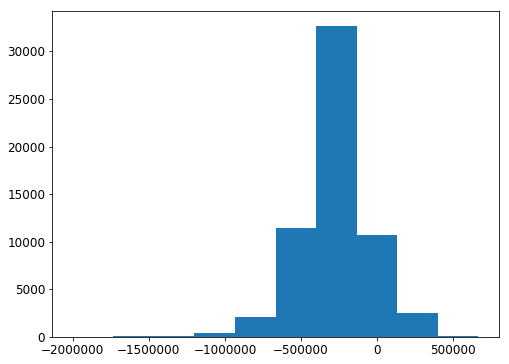

In [34]:
plt.figure(figsize=(8, 6))
_ = plt.hist(y_scores)

According to the book, SGD uses a cutoff of 0 by default. In order to get the decision function scores for each sample we need to re-run `cross_val_predict` with the option `method='decision_function'`.

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

Are the two scores above the same, or is the first one influenced by the random over-sampling?

Text(0, 0.5, 'Over-sampled Scores')

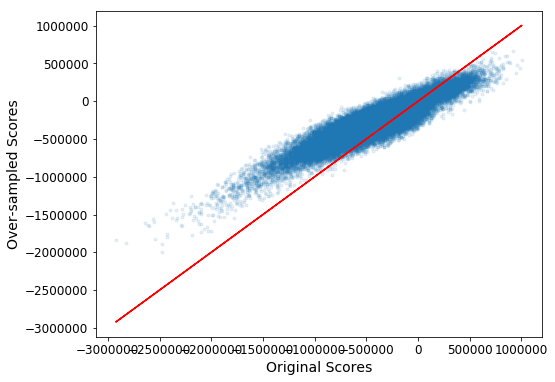

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(y_scores, y_scores_ros, '.', alpha=.1)
plt.plot(y_scores, y_scores, c='r')
plt.xlabel('Original Scores')
plt.ylabel('Over-sampled Scores')

The scores are clearly quite different. Let's use the `precision_recall_curve` to see how precision and recall change when varying the threshold. **TODO** read the source for this function.

In [47]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_train_5, y_scores)

In the first plot we show the precision and the recall as functions of the threshold.

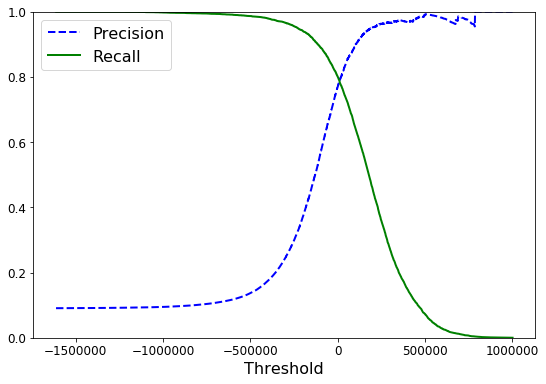

In [55]:
plt.figure(figsize=(9, 6))
ch3.plot_precision_recall_vs_threshold(prec, rec, thresh)

In the second plot we show precision as a function of recall.

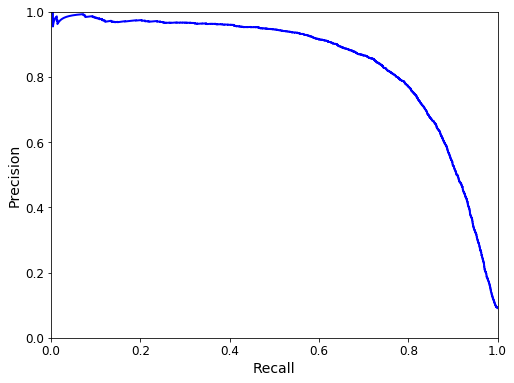

In [57]:
plt.figure(figsize=(8, 6))
ch3.plot_precision_vs_recall(prec, rec)

Does it make sense to plot the F1 score as a function of the thresholds? **TODO** in `ch3.plot_f1_scores_vs_thresholds` the F1 are one element longer than the thresholds. I have ignored the first value (it doesn't matter terribly much, I guess), but you should verify that this is correct.

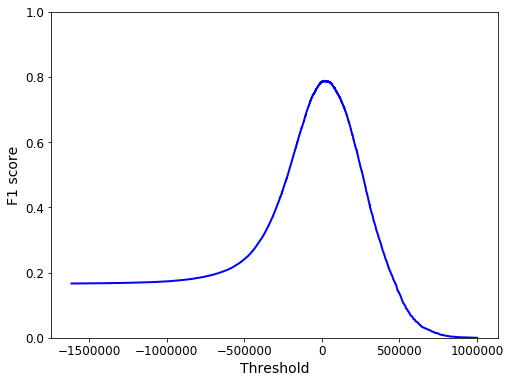

In [60]:
plt.figure(figsize=(8, 6))
ch3.plot_f1_scores_vs_thresholds(prec, rec, thresh)